# Import packages

In [77]:
import scanpy as sc
import os
import pandas as pd
import scenicplus
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pickle
import dill
import sys

%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(7,7), facecolor='white')

# Load data

In [2]:
# Working directories
work_dir = '/scratch/leuven/343/vsc34319/IBP/data/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'

local_state_dir = work_dir + 'mirror/state'
motif_path = state_dir + '/motifs/'
scratch_dir = os.getenv('VSC_SCRATCH')
mg_state = os.path.join(os.getenv('VSC_SCRATCH'), 'mg_state')

In [3]:
adata = sc.read_h5ad(os.path.join(state_dir, 'alzheimers.h5ad'))
cistopic_obj = dill.load(open(os.path.join(state_dir, 'cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(os.path.join(state_dir, 'motifs'), 'menr.pkl'), 'rb'))

In [4]:
adata = adata.raw.to_adata()

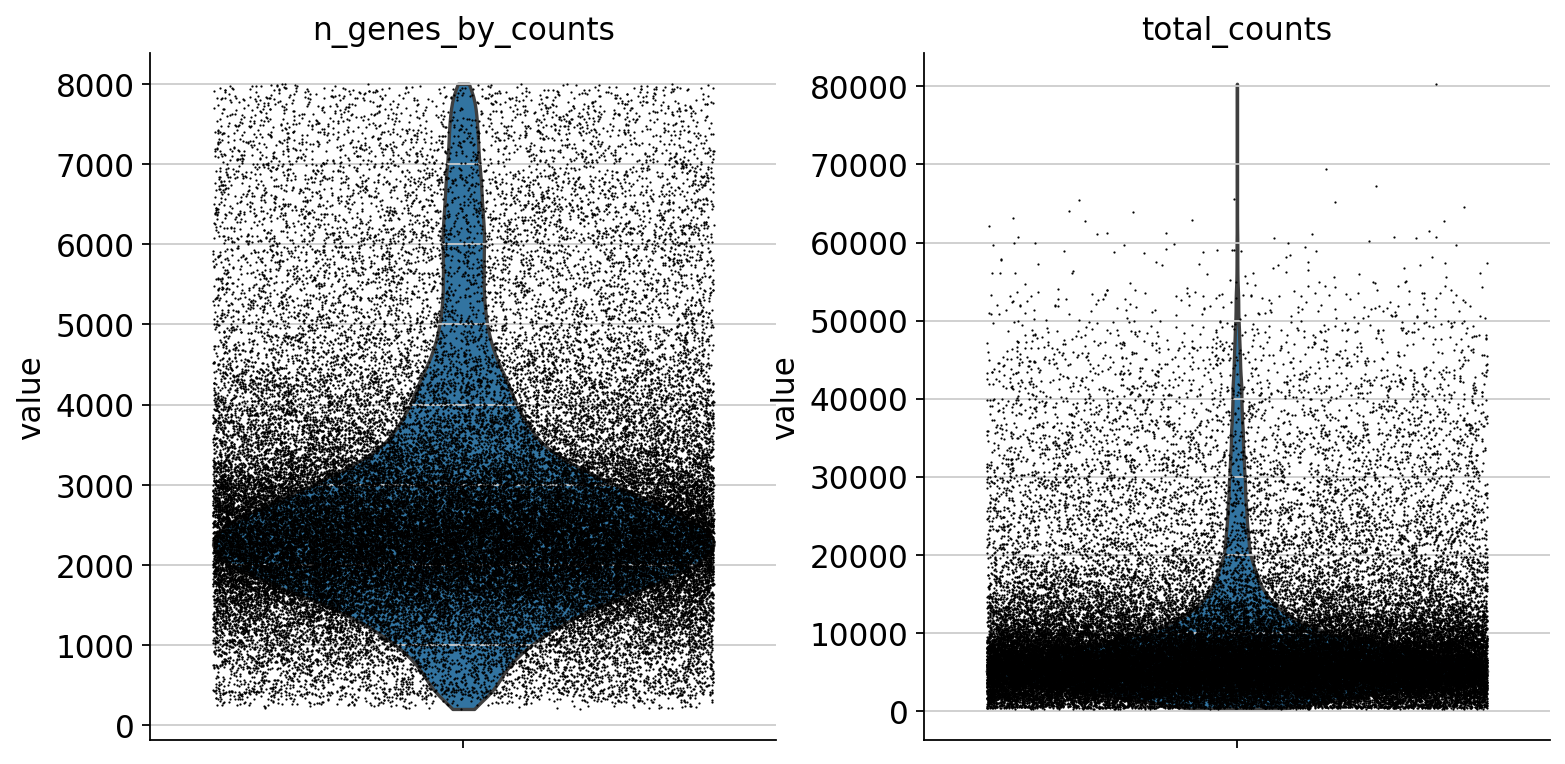

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.celltype == 'MG',]

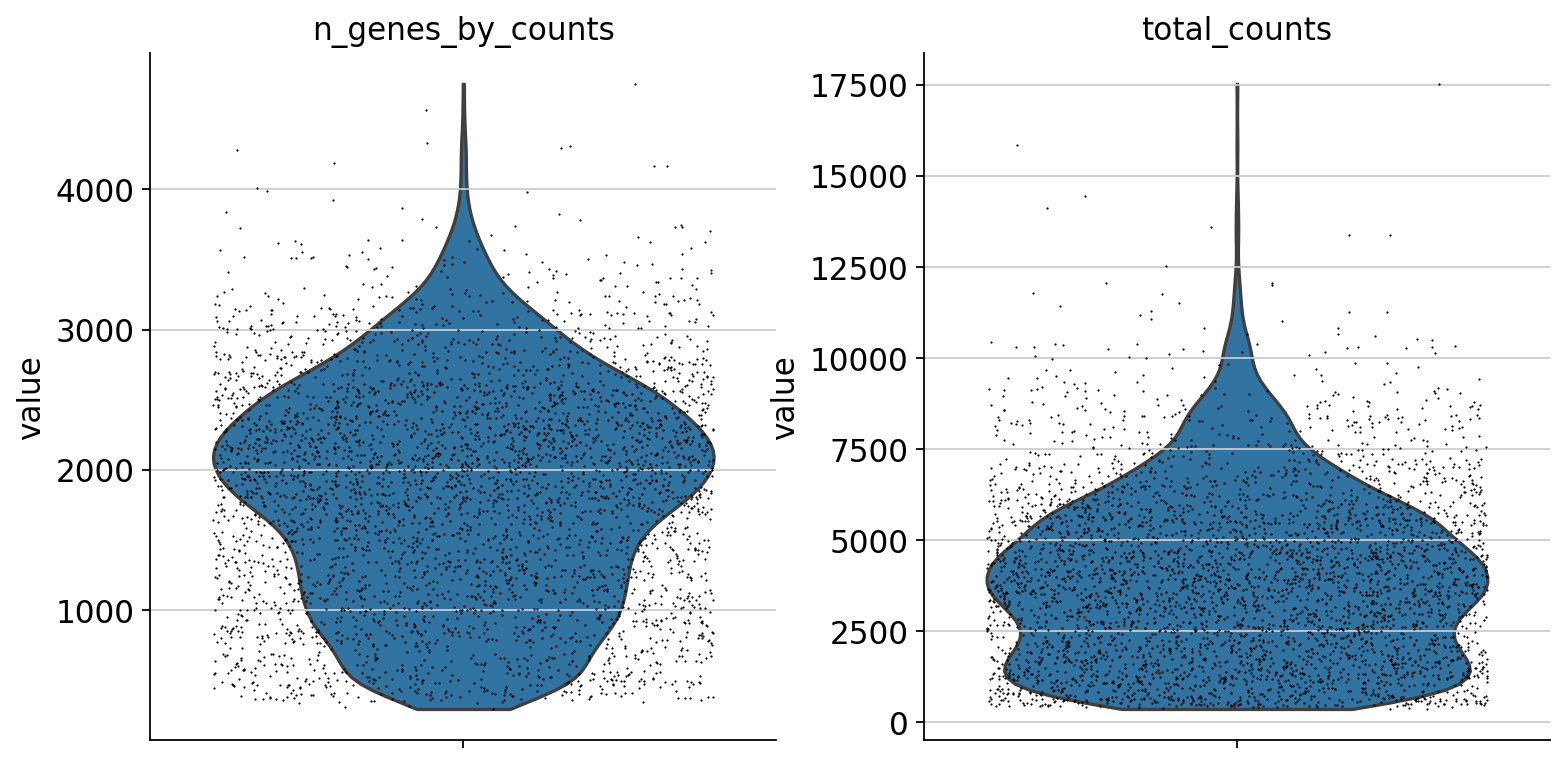

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

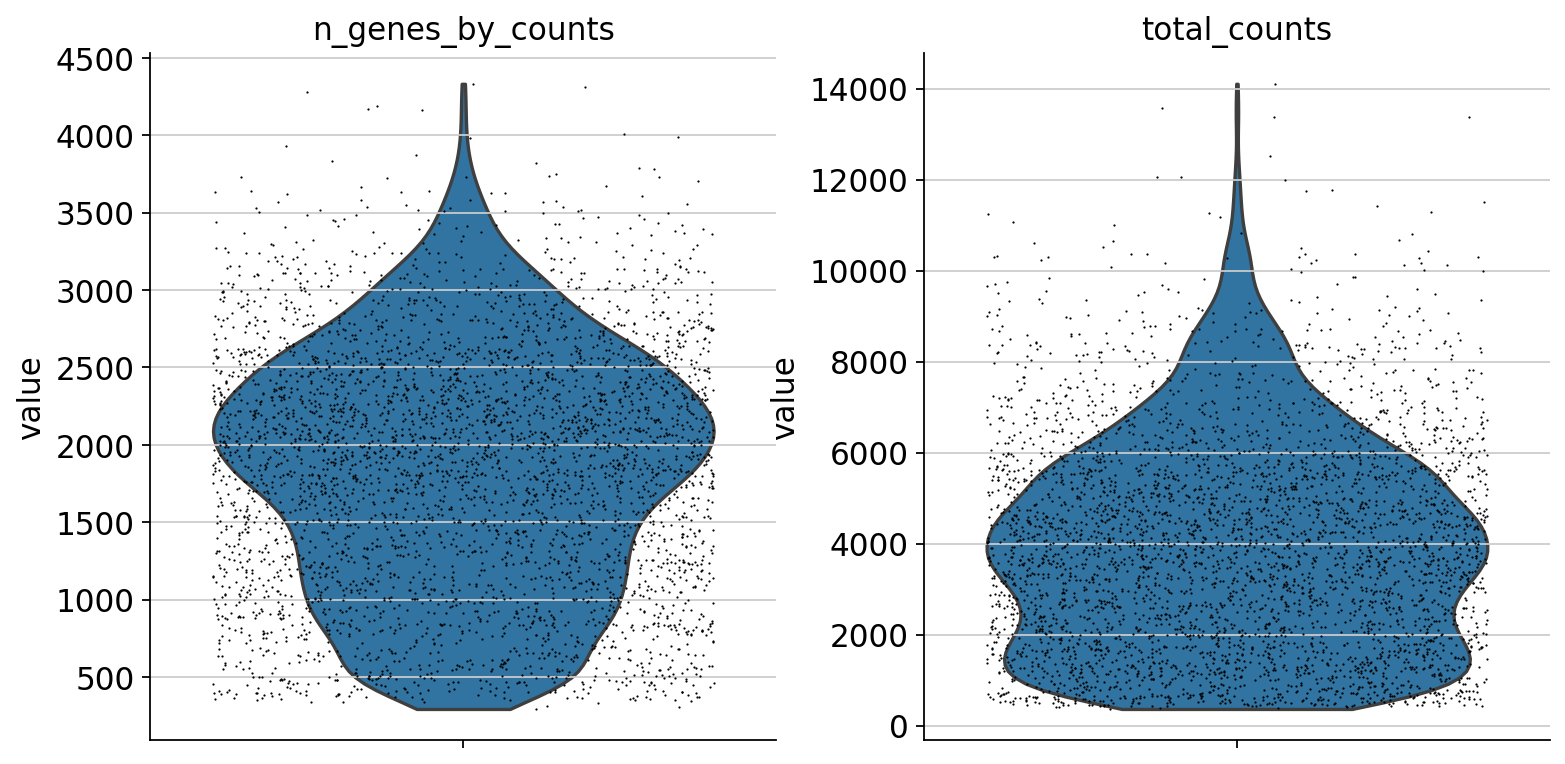

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 4500, :]
adata = adata[adata.obs.total_counts < 15000, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [9]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    multi_ome_mode = False,
    key_to_group_by = 'Diagnosis',
    nr_cells_per_metacells = 10)

2022-12-14 16:42:56,714 cisTopic     INFO     Imputing drop-outs
2022-12-14 16:43:37,118 cisTopic     INFO     Scaling
2022-12-14 16:44:34,520 cisTopic     INFO     Keep non zero rows
2022-12-14 16:45:45,595 cisTopic     INFO     Imputed accessibility sparsity: 0.7658145431815311
2022-12-14 16:45:45,601 cisTopic     INFO     Create CistopicImputedFeatures object
2022-12-14 16:45:45,602 cisTopic     INFO     Making matrix sparse
2022-12-14 16:51:37,206 cisTopic     INFO     Done!
2022-12-14 16:51:37,423 create scenicplus object INFO     Following annotations were found in both assays under key Diagnosis:
	AD, Control.
Keeping 4072 cells for RNA and 31713 for ATAC.
2022-12-14 16:52:59,487 create scenicplus object INFO     Automatically set `nr_metacells` to: AD: 540, Control: 274
2022-12-14 16:52:59,490 create scenicplus object INFO     Generating pseudo multi-ome data


In [10]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 23617 out of 36066
host: 104
Genes recovered: 23838 out of 36066
host: 103
Genes recovered: 34325 out of 36066
host: 102


/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 34418 out of 36066
host: 101
Genes recovered: 34643 out of 36066
host: 100
Genes recovered: 34768 out of 36066
host: 99
Genes recovered: 34905 out of 36066
host: 98
Genes recovered: 35161 out of 36066
host: 97
Genes recovered: 35337 out of 36066
host: 96
Genes recovered: 35496 out of 36066
host: 95
Genes recovered: 35784 out of 36066
host: 94
Genes recovered: 35896 out of 36066
host: 93
Genes recovered: 35306 out of 36066
host: 92
Genes recovered: 35181 out of 36066
host: 91
Genes recovered: 34863 out of 36066
host: 90
Host not reachable
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 23576 out of 36066
host: 77
Genes recovered: 23044 out of 36066
host: 75
Host not reachable
host: 54
Host not reachable
version: 94 has the largest overlap, use http://oct2018.archive.ensembl.org/ as biomart host


In [11]:
biomart_host = "http://oct2018.archive.ensembl.org/"

In [12]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    sys.stderr = open(os.path.join(scratch_dir, 'err-odc.log'), "w")
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['Diagnosis'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = os.path.join(local_state_dir, 'TF_names_v_1.01.txt'),
        save_path = os.path.join(scratch_dir, 'scenicplus.mg'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = True,
        export_to_UCSC_file = True,
        path_bedToBigBed = os.path.join(local_state_dir, 'bin'),
        n_cpu = 20,
        _temp_dir = os.path.join(scratch_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(scratch_dir, 'scenicplus.mg/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-12-14 16:54:41,515 SCENIC+_wrapper INFO     /scratch/leuven/343/vsc34319/scenicplus.mg folder already exists.
2022-12-14 16:54:41,517 SCENIC+_wrapper INFO     Merging cistromes
2022-12-14 16:58:23,550 SCENIC+_wrapper INFO     Getting search space
2022-12-14 16:58:26,239 R2G          INFO     Downloading gene annotation from biomart dataset: hsapiens_gene_ensembl
2022-12-14 16:58:42,736 R2G          INFO     Downloading chromosome sizes from: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
2022-12-14 16:58:44,440 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2022-12-14 16:58:46,638 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2022-12-14 16:59:00,376 R2G          INFO     Intersecting with regions.
2022-12-14 16:59:01,800 R2G          INFO     Calculating distances from region to gene
2022-

... storing 'Diagnosis' as categorical


2022-12-14 20:19:06,500 SCENIC+      INFO     Finished calculating DEGs for variable Diagnosis
2022-12-14 20:19:06,501 SCENIC+      INFO     Calculating DARs for variable Diagnosis
2022-12-14 20:19:22,539 SCENIC+      INFO     There are 71620 variable features


... storing 'Diagnosis' as categorical


2022-12-14 20:19:29,521 SCENIC+      INFO     Finished calculating DARs for variable Diagnosis
2022-12-14 20:19:29,523 SCENIC+_wrapper INFO     Exporting to loom file
2022-12-14 20:19:29,525 SCENIC+      INFO     Formatting data
2022-12-14 20:19:32,578 SCENIC+      INFO     Creating minimal loom
2022-12-14 20:19:37,509 SCENIC+      INFO     Adding annotations
2022-12-14 20:19:39,026 SCENIC+      INFO     Adding clusterings
2022-12-14 20:19:39,031 SCENIC+      INFO     Adding markers
2022-12-14 20:19:39,261 SCENIC+      INFO     Exporting
2022-12-14 20:19:46,524 SCENIC+      INFO     Formatting data
2022-12-14 20:20:11,438 SCENIC+      INFO     Creating minimal loom
2022-12-14 20:22:17,673 SCENIC+      INFO     Adding annotations
2022-12-14 20:22:42,054 SCENIC+      INFO     Adding clusterings
2022-12-14 20:22:42,062 SCENIC+      INFO     Adding markers
2022-12-14 20:22:47,465 SCENIC+      INFO     Exporting
2022-12-14 20:24:35,960 SCENIC+_wrapper INFO     Exporting to UCSC
2022-12-14 2

... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical
... storing 'Diagnosis' as categorical


In [13]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 814 x 36066 and n_cells x n_regions = 814 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

# Downstream Analysis


In [50]:
import dill
scplus_obj = dill.load(open(os.path.join(scratch_dir, 'scenicplus.mg/scplus_obj.pkl'), 'rb'))

In [51]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 814 x 36066 and n_cells x n_regions = 814 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [52]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID3A_+_(494r),ARID3A_+_(261g),ARID3A,False,chr8:141299335-141299835,DENND3,0.008097,0.062585,0.000507,0.000507,2.394023,1,0.278952,0.667817,0.667817,ARID3A_+_+
1,ARID3A_+_(494r),ARID3A_+_(261g),ARID3A,False,chr8:141174834-141175334,DENND3,0.030955,0.060813,0.001882,0.001882,2.394023,1,0.278952,0.667817,0.667817,ARID3A_+_+
2,ARID3A_+_(494r),ARID3A_+_(261g),ARID3A,False,chr8:141194022-141194522,DENND3,0.011563,0.075435,0.000872,0.000872,2.394023,1,0.278952,0.667817,0.667817,ARID3A_+_+
3,ARID3A_+_(494r),ARID3A_+_(261g),ARID3A,False,chr8:141183427-141183927,DENND3,0.033205,0.131000,0.004350,0.004350,2.394023,1,0.278952,0.667817,0.667817,ARID3A_+_+
4,ARID3A_+_(494r),ARID3A_+_(261g),ARID3A,False,chr1:151840951-151841451,SNX27,0.006845,0.071240,0.000488,0.000488,1.828078,1,0.117327,0.214483,0.214483,ARID3A_+_+


In [53]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus.mg/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(scratch_dir, 'scenicplus.mg/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [54]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 814 x 36066 and n_cells x n_regions = 814 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [55]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF ARID3A in context frozenset({'BASC binarized', '0.9 quantile', '0.95 quantile', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'positive tf2g', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Top 5 region-to-gene links per gene'}).
 	This eRegulon has 494 target regions and 261 target genes.,
 eRegulon for TF ARID5B in context frozenset({'0.9 quantile', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'positive tf2g', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Top 5 region-to-gene links per gene'}).
 	This eRegulon has 36 target regions and 32 target genes.,
 eRegulon for TF ATF2 in context frozenset({'BASC binarized', '0.9 quantile', '0.95 quantile', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'positive tf2g', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Top 5 region-to-gene links per gene'}).
 	This eRegulon has 193 target regions 

In [56]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: ARID3A_(26066r)
context: frozenset({'BASC binarized', '0.9 quantile', '0.95 quantile', 'positive r2g', 'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'positive tf2g', '0.85 quantile', 'Top 15 region-to-gene links per gene', 'Top 5 region-to-gene links per gene'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 261
n_target_regions: 494
regions2genes: [r2g(region='chr8:141299335-141299835', target='DENND3', importance=0.008097286375664679, rho=0.06258540283561433, importance_x_rho=0.0005067719296963054, importance_x_abs_rho=0.0005067719296963054), r2g(region='chr1:151840951-151841451', target='SNX27', importance=0.006845243351027109, rho=0.07124017612131606, importance_x_rho=0.00048765634192043895, importance_x_abs_rho=0.00048765634192043895), r2g(region='chr14:99946782-99947282', target='EVL', importance=0.019501021469949902, rho=0.15006728753450077, importance_x_rho=0.0029264653961

In [57]:
scplus_obj.metadata_cell

,Diagnosis
AD_0,AD
AD_1,AD
AD_2,AD
AD_3,AD
AD_4,AD
...,...
Control_269,Control
Control_270,Control
Control_271,Control
Control_272,Control


In [58]:
eRegulon_metadata = scplus_obj.uns['eRegulon_metadata_filtered']
#eRegulon_metadata
eRegulon_metadata.loc[eRegulon_metadata['Gene'] == 'DPYD']
#np.set_printoptions(threshold=sys.maxsize)
#eRegulon_metadata['Gene'].unique()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
355,BACH1_+_(373r),BACH1_+_(277g),BACH1,False,chr1:97849855-97850355,DPYD,0.001904,0.068655,0.000131,0.000131,2.340990,1,0.234181,0.548214,0.548214,BACH1_+_+
81,CEBPB_+_(152r),CEBPB_+_(113g),CEBPB,False,chr1:97145161-97145661,DPYD,0.004381,0.065314,0.000286,0.000286,1.910890,1,0.310423,0.593184,0.593184,CEBPB_+_+
82,CEBPB_+_(152r),CEBPB_+_(113g),CEBPB,False,chr1:97936942-97937442,DPYD,0.004806,0.159633,0.000767,0.000767,1.910890,1,0.310423,0.593184,0.593184,CEBPB_+_+
928,E2F3_+_(1502r),E2F3_+_(646g),E2F3,False,chr1:97920836-97921336,DPYD,0.051512,0.330172,0.017008,0.017008,1.381192,1,0.341027,0.471024,0.471024,E2F3_+_+
929,E2F3_+_(1502r),E2F3_+_(646g),E2F3,False,chr1:98054032-98054532,DPYD,0.003266,0.195447,0.000638,0.000638,1.381192,1,0.341027,0.471024,0.471024,E2F3_+_+
1137,ELF1_+_(1698r),ELF1_+_(728g),ELF1,False,chr1:97920836-97921336,DPYD,0.051512,0.330172,0.017008,0.017008,2.382352,1,0.334555,0.797028,0.797028,ELF1_+_+
1138,ELF1_+_(1698r),ELF1_+_(728g),ELF1,False,chr1:97138132-97138632,DPYD,0.002266,0.171069,0.000388,0.000388,2.382352,1,0.334555,0.797028,0.797028,ELF1_+_+
862,ETS2_+_(1292r),ETS2_+_(530g),ETS2,False,chr1:97138132-97138632,DPYD,0.002266,0.171069,0.000388,0.000388,2.431524,1,0.321379,0.781440,0.781440,ETS2_+_+
166,HIF1A_+_(279r),HIF1A_+_(208g),HIF1A,False,chr1:97145161-97145661,DPYD,0.004381,0.065314,0.000286,0.000286,2.009330,1,0.311438,0.625782,0.625782,HIF1A_+_+
237,IKZF1_+_(1062r),IKZF1_+_(517g),IKZF1,False,chr1:97920836-97921336,DPYD,0.051512,0.330172,0.017008,0.017008,2.473504,1,0.338294,0.836771,0.836771,IKZF1_+_+


In [59]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Diagnosis',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based',
        nr_cells = 50,
        nr_pseudobulks = 10)
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'Diagnosis',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based',
        nr_cells = 50,
        nr_pseudobulks = 10)

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Diagnosis',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'Diagnosis',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [60]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']

0        MEF2C_+_(616r)
1         SOX6_+_(118r)
2          E2F5_+_(26r)
3      ZNF148_+_(1160r)
4          EGR1_+_(38r)
             ...       
136        KLF6_-_(37r)
137      RUNX1_+_(412r)
138        THRB_-_(31r)
139        JDP2_-_(16r)
140       ATF2_+_(193r)
Name: Cistrome, Length: 140, dtype: object

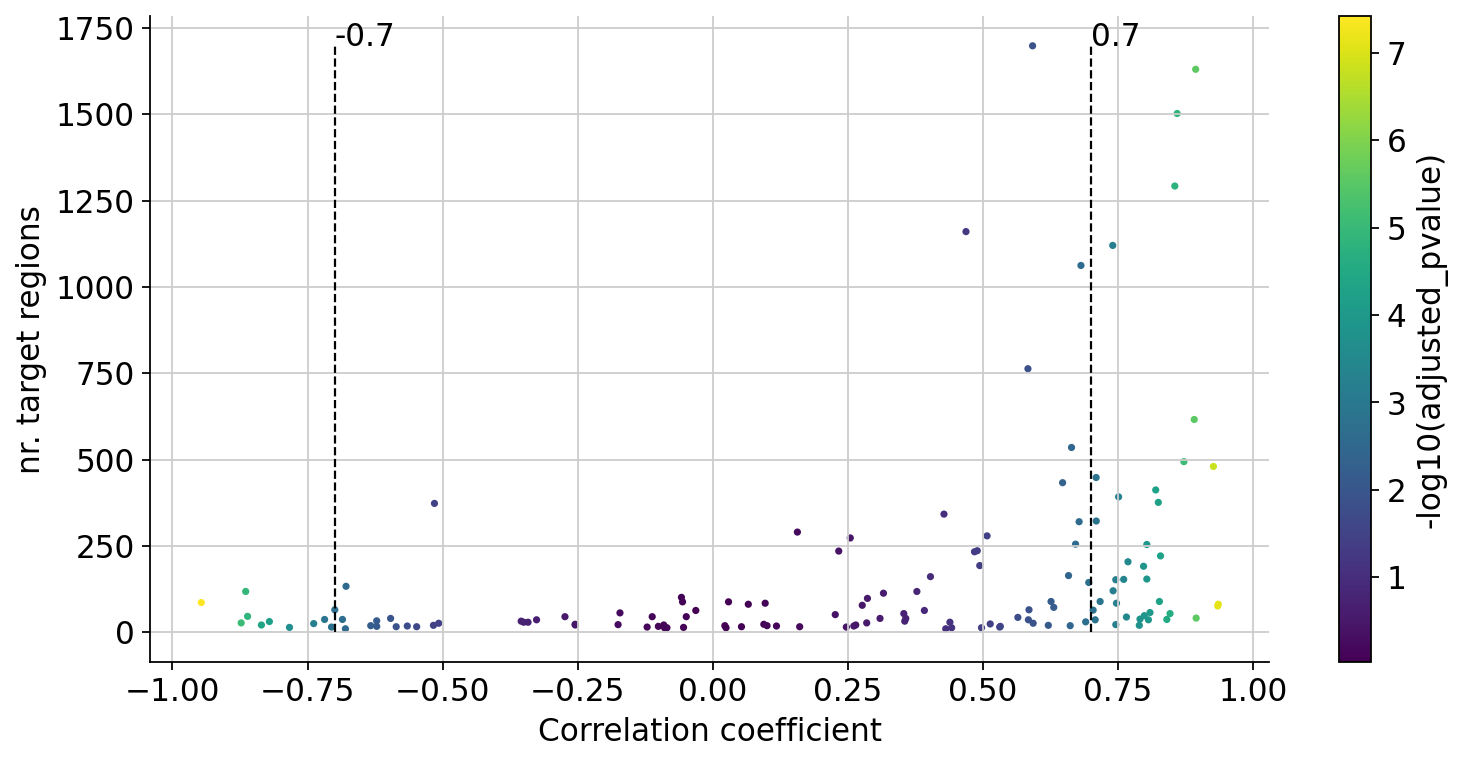

In [61]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.7, 0.7],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [62]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 47 eRegulons


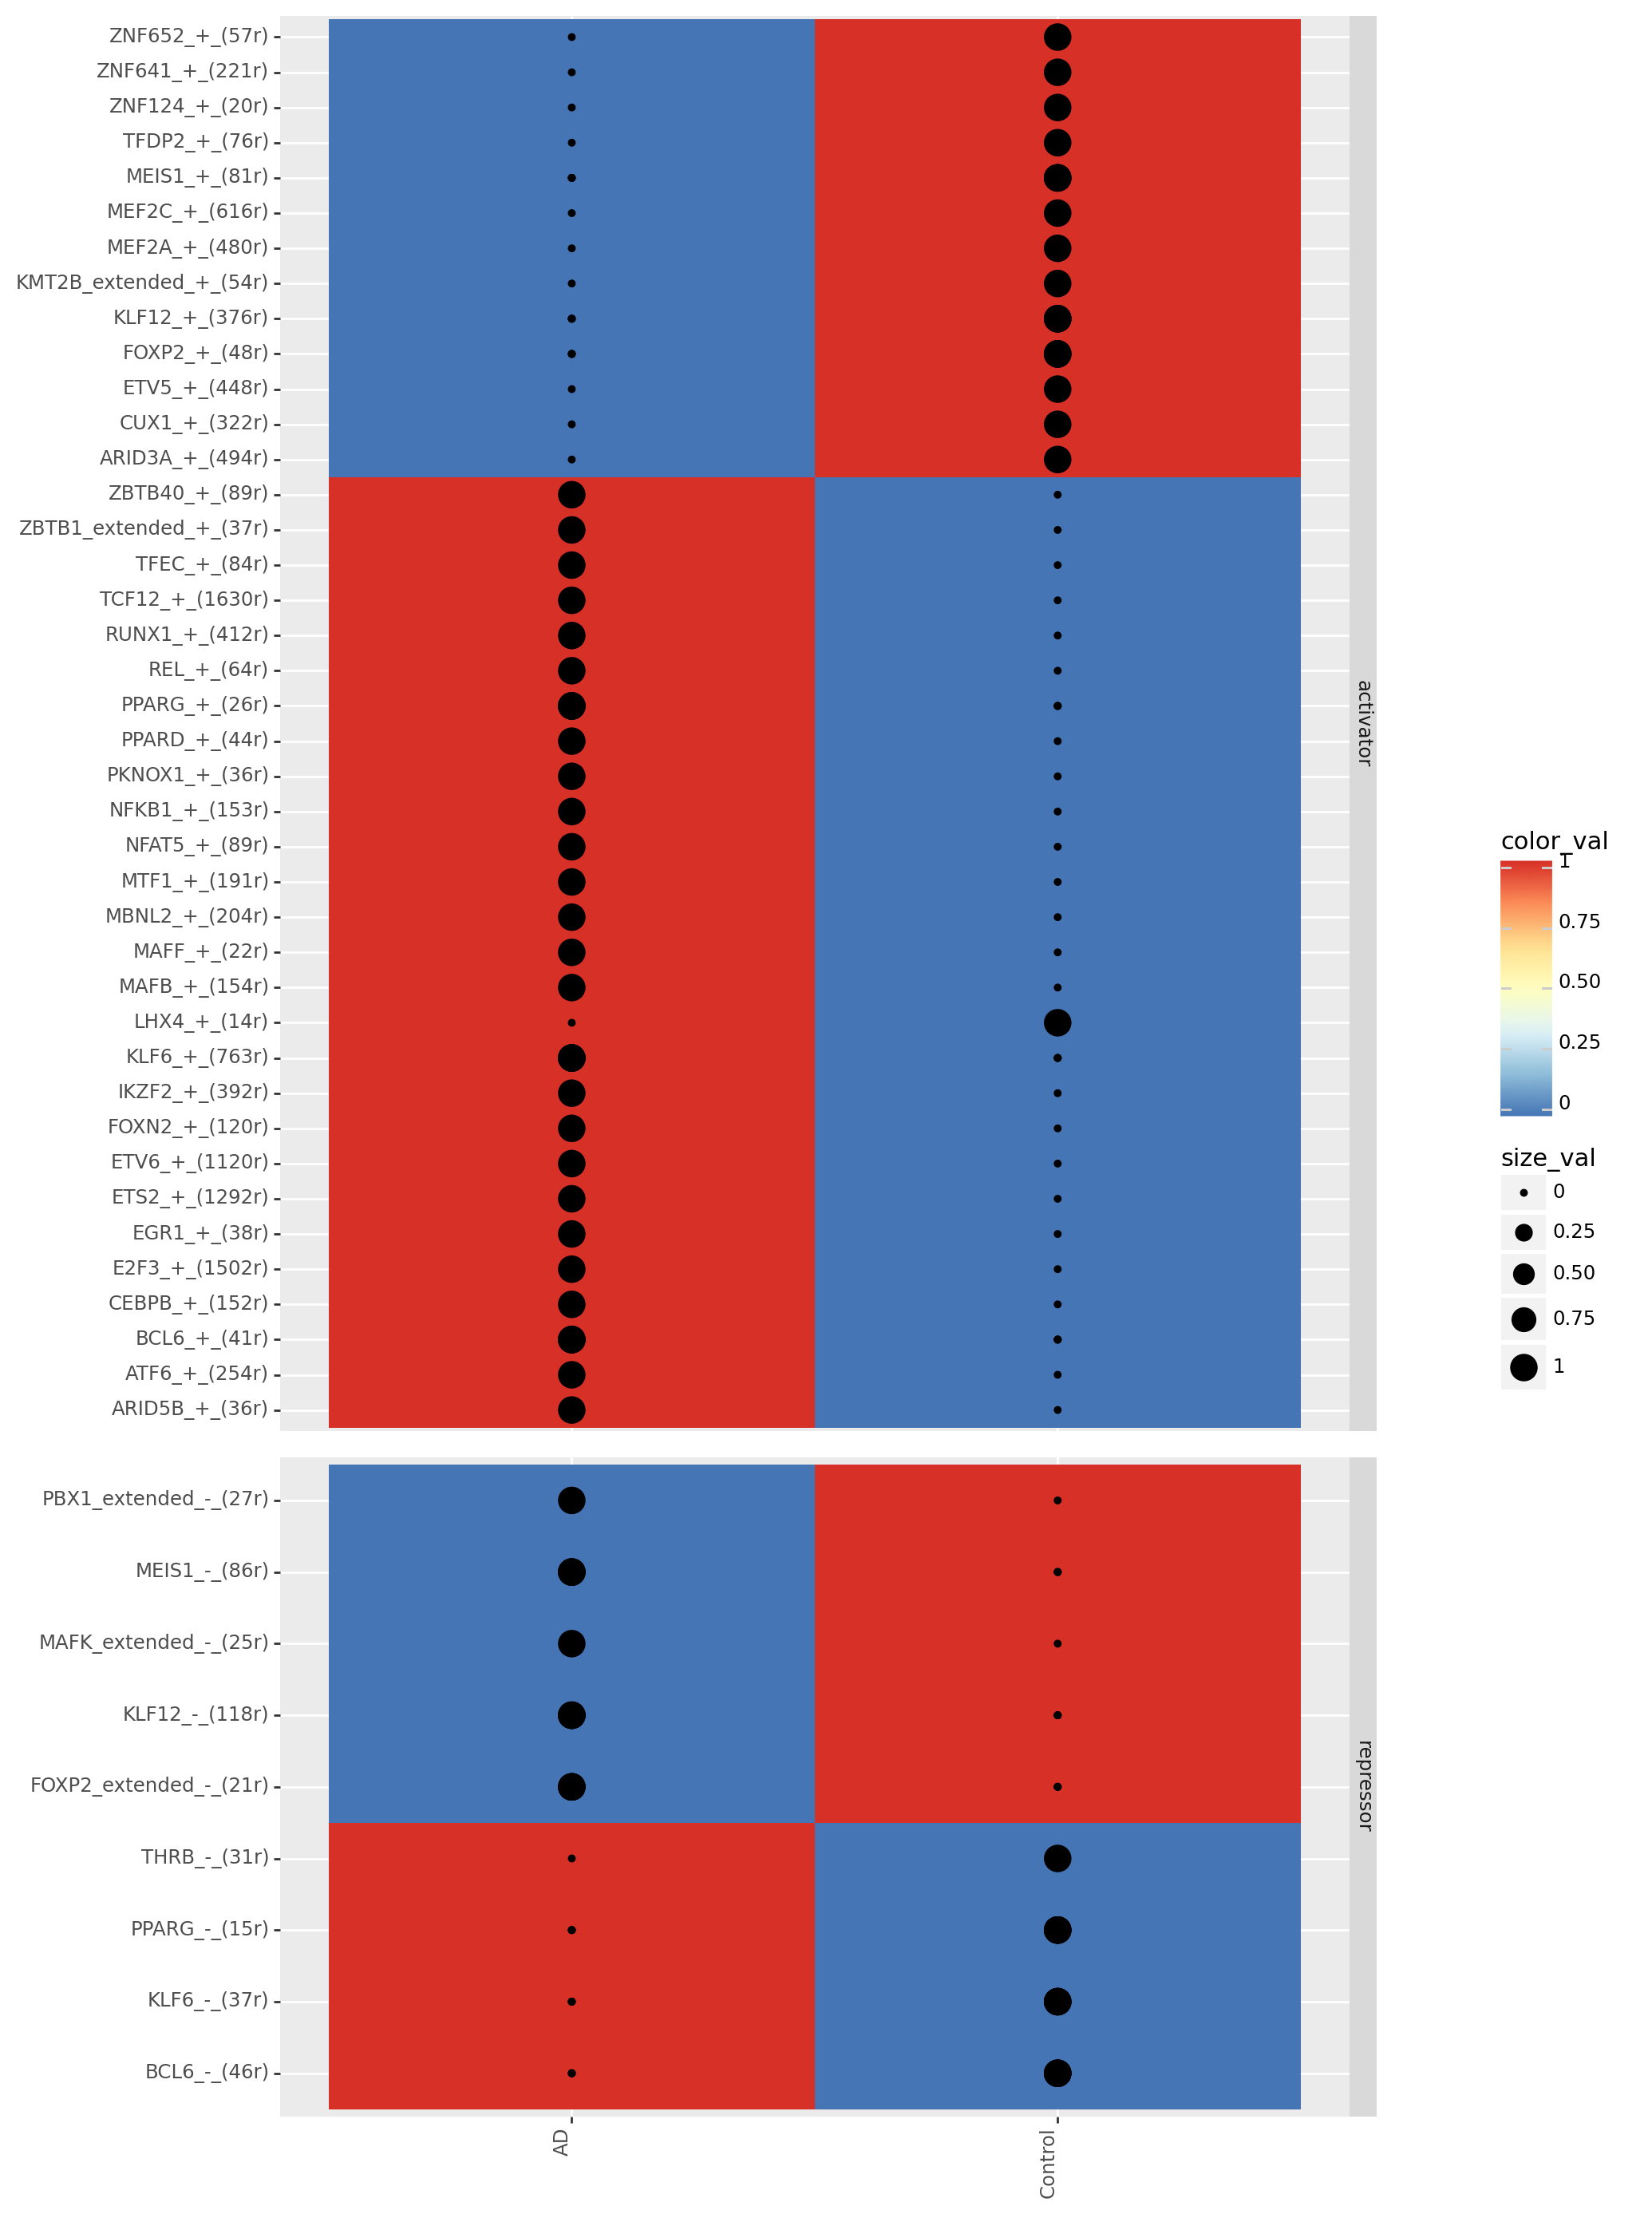

<ggplot: (1399580196145)>

In [87]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'Diagnosis',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        index_order = ['AD', 'Control'],
        figsize = (10, 14),
        orientation = 'vertical')

In [92]:
scplus_obj.uns['selected_eRegulon']

{'Gene_based': ['MEF2C_+_(366g)',
  'EGR1_+_(26g)',
  'TFEC_+_(81g)',
  'MEIS1_-_(53g)',
  'MAFK_extended_-_(18g)',
  'ETV6_+_(567g)',
  'ETS2_+_(530g)',
  'REL_+_(52g)',
  'MEIS1_+_(45g)',
  'MEF2A_+_(325g)',
  'ZBTB40_+_(77g)',
  'KLF12_-_(58g)',
  'E2F3_+_(646g)',
  'TCF12_+_(884g)',
  'MAFB_+_(121g)',
  'CEBPB_+_(113g)',
  'PKNOX1_+_(34g)',
  'MAFF_+_(19g)',
  'ARID5B_+_(32g)',
  'FOXP2_+_(46g)',
  'KLF12_+_(215g)',
  'ZNF124_+_(20g)',
  'CUX1_+_(269g)',
  'FOXP2_extended_-_(11g)',
  'NFKB1_+_(126g)',
  'BCL6_+_(40g)',
  'ZBTB1_extended_+_(38g)',
  'FOXN2_+_(109g)',
  'ZNF641_+_(143g)',
  'TFDP2_+_(66g)',
  'NFAT5_+_(73g)',
  'PPARG_-_(13g)',
  'PBX1_extended_-_(26g)',
  'ETV5_+_(256g)',
  'MBNL2_+_(140g)',
  'ARID3A_+_(261g)',
  'PPARD_+_(40g)',
  'BCL6_-_(31g)',
  'LHX4_+_(11g)',
  'ZNF652_+_(47g)',
  'KMT2B_extended_+_(47g)',
  'MTF1_+_(142g)',
  'IKZF2_+_(191g)',
  'KLF6_-_(15g)',
  'RUNX1_+_(264g)',
  'THRB_-_(21g)',
  'ATF6_+_(226g)'],
 'Region_based': ['MEF2C_+_(616r)',
  'E

In [93]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 814 x 36066 and n_cells x n_regions = 814 x 820223
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'Diagnosis'
	menr:'CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'
	dr_cell:'eRegulons_UMAP', 'eRegulons_tSNE'

In [113]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'Diagnosis',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered',
        scale=False)

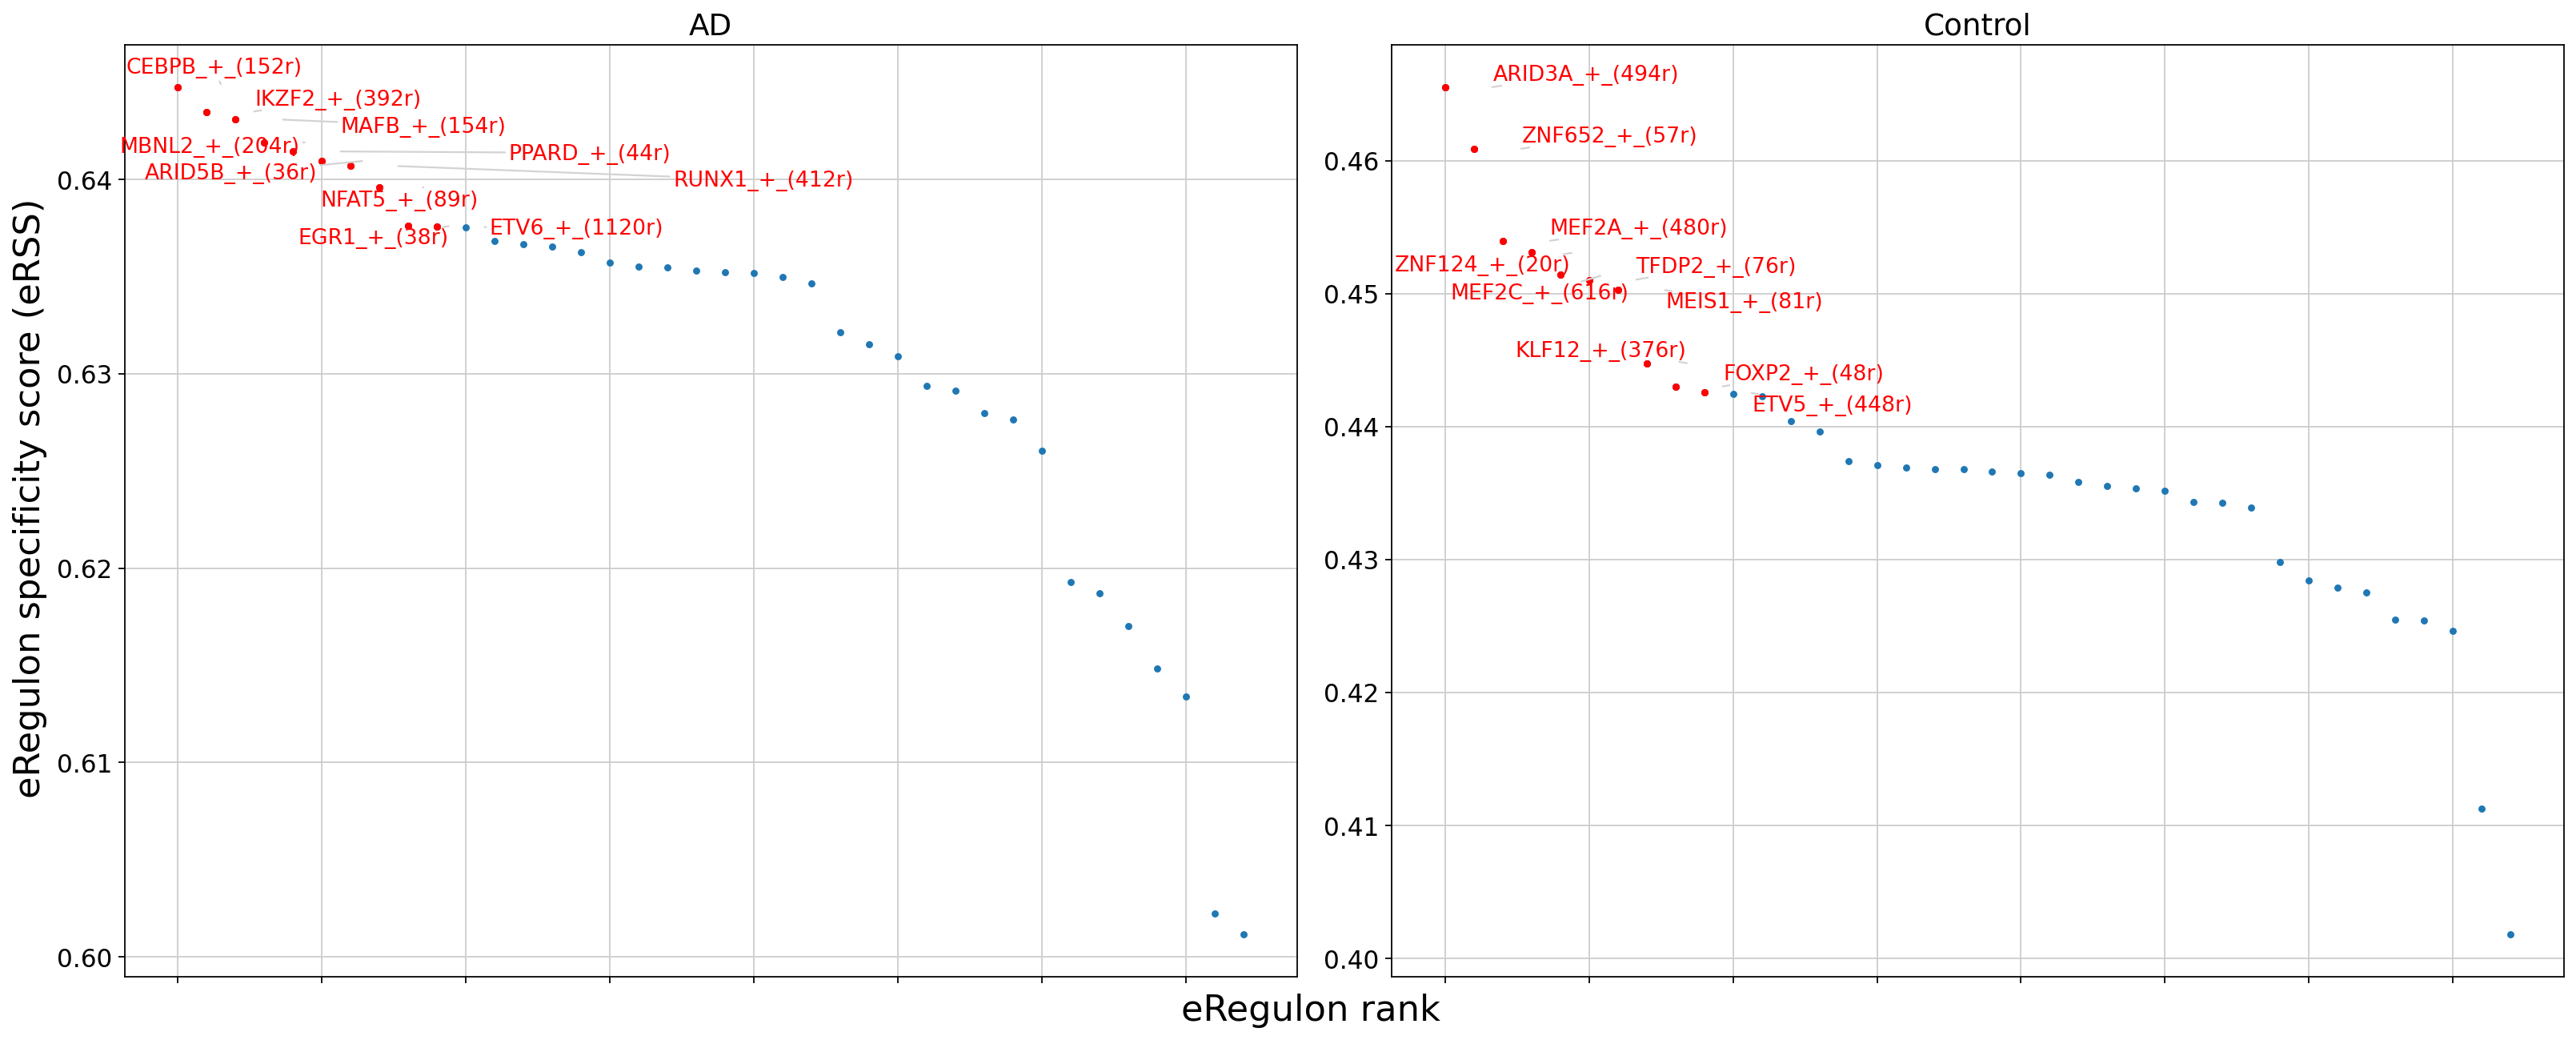

In [115]:
plot_rss(scplus_obj, 'Diagnosis_filtered', num_columns=2, top_n=10, figsize = (20, 8))

In [96]:
flat_list = lambda t: [item for sublist in t for item in sublist]
selected_markers = list(set(flat_list(
    [scplus_obj.uns['RSS']['Diagnosis_filtered'].loc[celltype].sort_values(ascending = False).head(10).index.to_list()
    for celltype in scplus_obj.uns['RSS']['Diagnosis_filtered'].index])))

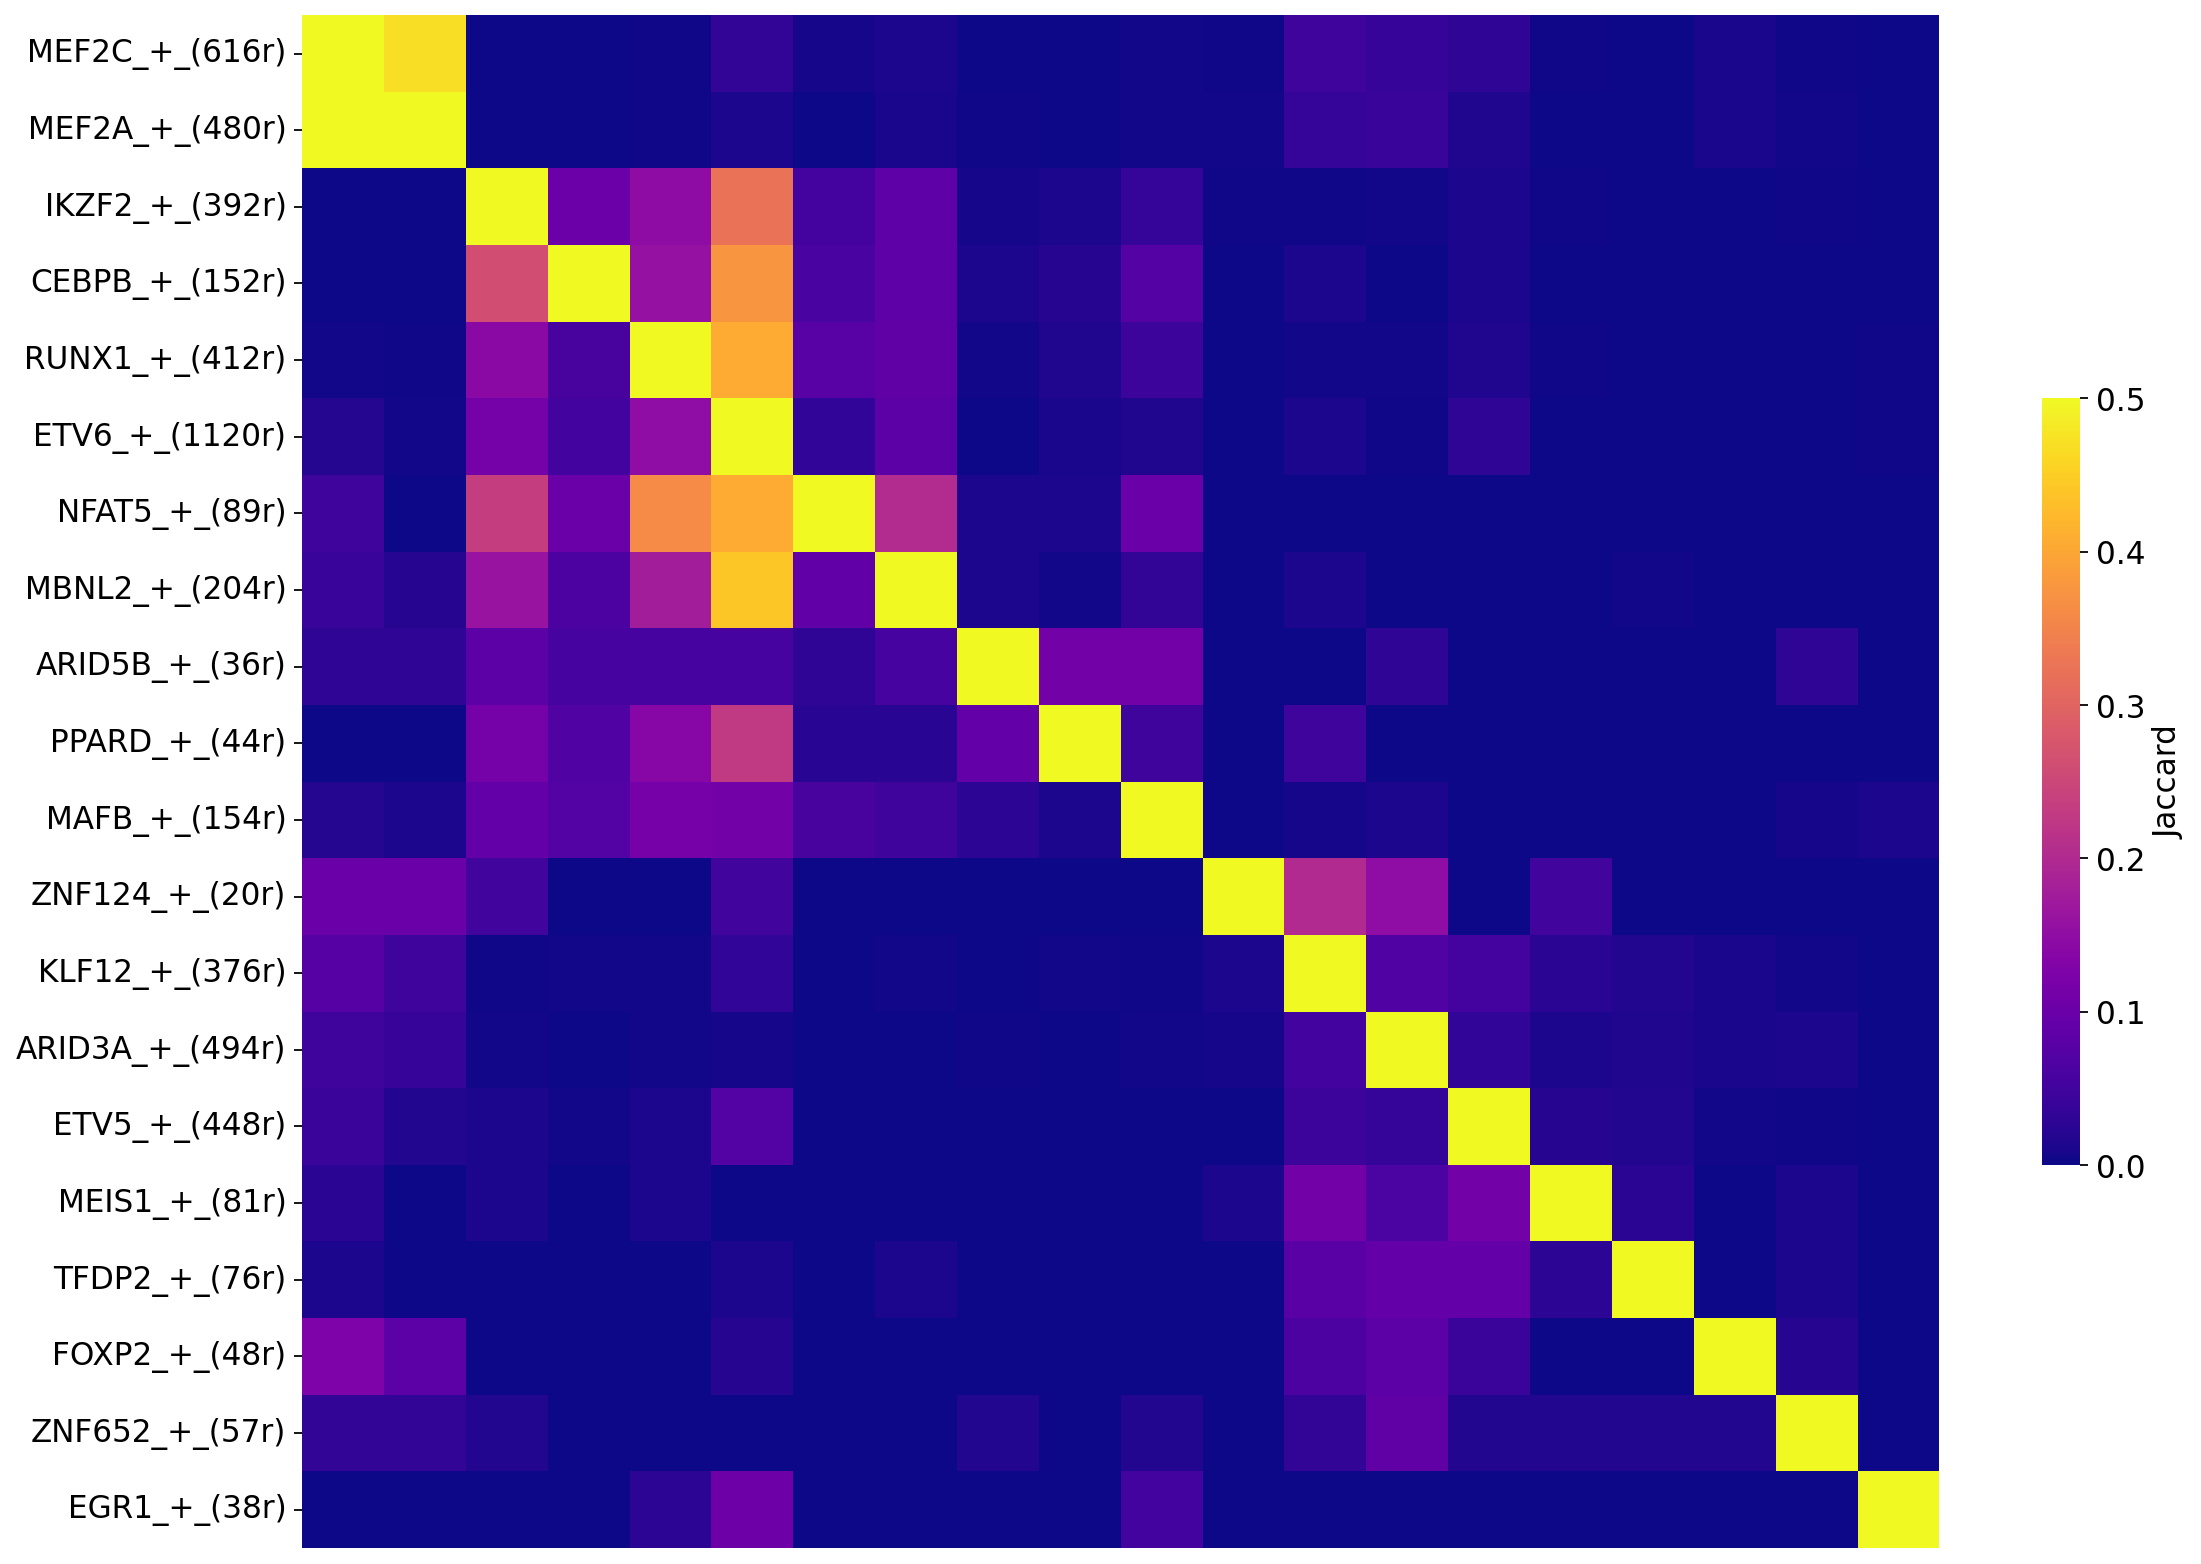

In [105]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Region_based',
        use_plotly = False,
        selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
        figsize = (15, 10), return_data = True, vmax = 0.5, cmap = 'plasma')

In [98]:
selected_markers

['EGR1_+_(38r)',
 'ZNF652_+_(57r)',
 'ETV6_+_(1120r)',
 'MEF2A_+_(480r)',
 'RUNX1_+_(412r)',
 'ZNF124_+_(20r)',
 'IKZF2_+_(392r)',
 'MEIS1_+_(81r)',
 'PPARD_+_(44r)',
 'CEBPB_+_(152r)',
 'KLF12_+_(376r)',
 'ETV5_+_(448r)',
 'MBNL2_+_(204r)',
 'FOXP2_+_(48r)',
 'MAFB_+_(154r)',
 'ARID3A_+_(494r)',
 'ARID5B_+_(36r)',
 'TFDP2_+_(76r)',
 'NFAT5_+_(89r)',
 'MEF2C_+_(616r)']

In [99]:
from pycisTopic.diff_features import find_highly_variable_features
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=5000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=2300, plot = False)

2022-12-14 21:05:03,544 cisTopic     INFO     Calculating mean
2022-12-14 21:05:03,555 cisTopic     INFO     Calculating variance
2022-12-14 21:05:03,717 cisTopic     INFO     Done!
2022-12-14 21:05:03,750 cisTopic     INFO     Calculating mean
2022-12-14 21:05:03,755 cisTopic     INFO     Calculating variance
2022-12-14 21:05:03,828 cisTopic     INFO     Done!


<Figure size 560x560 with 0 Axes>

<Figure size 560x560 with 0 Axes>

In [119]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = ['MEIS1', 'NFAT5'],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['Diagnosis'])

In [120]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'MEIS1': 'Orange', 'NFAT5': 'Blue'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'MEIS1': 'Orange', 'NFAT5': 'Blue'}},
                                    'Gene': {'variable': 'Diagnosis_Log2FC_AD', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'Diagnosis_Log2FC_AD', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'Diagnosis_Log2FC_AD', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'Diagnosis_Log2FC_AD', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

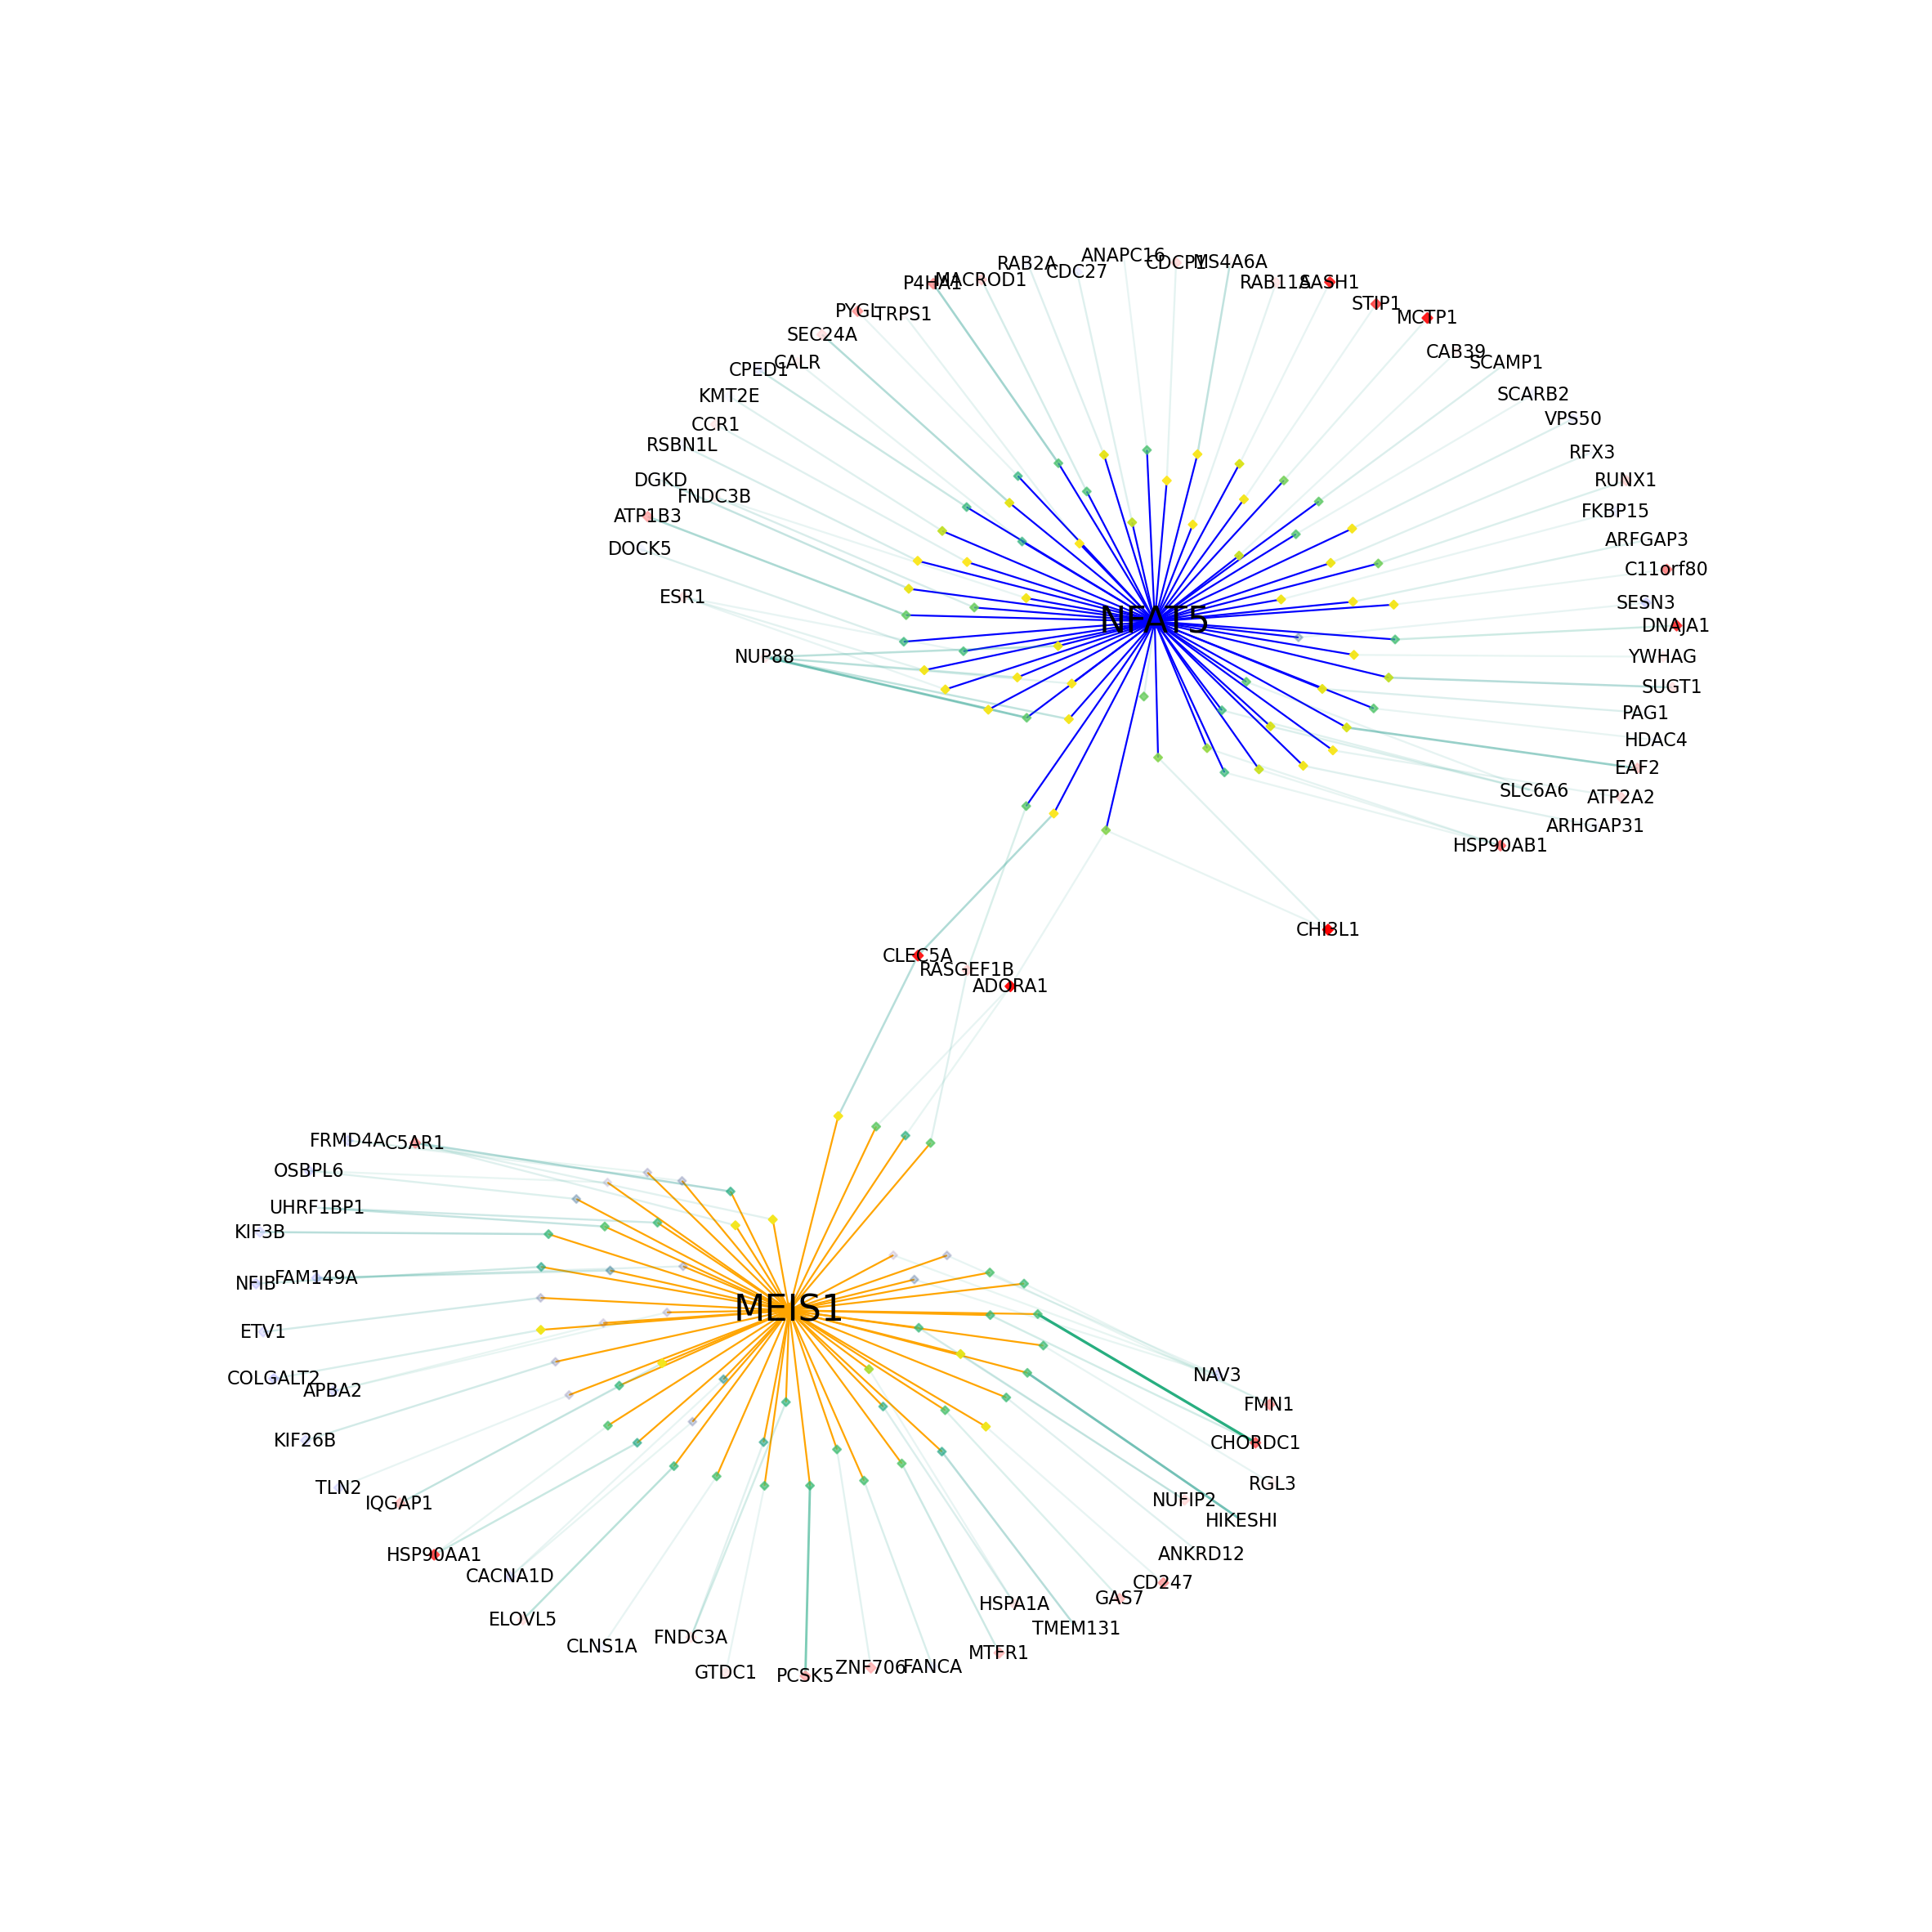

In [121]:
plt.figure(figsize=(15,15))
plot_networkx(G, pos)

In [122]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'network_MG_MEIS1_NFAT5.cys'))